In [1]:
from ING_PRO.mvtec2d import MVTec2D
from torchvision import transforms as T
from torch.utils.data import  ConcatDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from ING_PRO.AEUnetOri import ReconstructiveSubNetwork as ReconstructiveSubNetworkOri
from ING_PRO.loss import SSIM
from torch import Tensor
import torch
from torch import optim
from ING_PRO.loss import SSIM
import os
import numpy as np
from typing import Any, List, Optional, Tuple, Union
import torch.nn.functional as fn
import kornia
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torchvision.transforms.functional as TF
import random

In [2]:
def weights_init(m):
    """
    init weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [3]:
def random_corruption(image, corruption_prob=0.1, corruption_size=(30, 50), noise_std_range=(0.1, 0.5)):
    # 随机生成一个概率，以确定是否进行局部损坏
    if torch.rand(1).item() < corruption_prob:
        # 随机生成损坏区域的位置
        image_size = image.size()[-2:]
        top = random.randint(0, image_size[0] - corruption_size[0])
        left = random.randint(0, image_size[1] - corruption_size[1])

        # 随机选择将区域设置为全黑或全白
        if torch.rand(1).item() < 0.5:
            corrupted_image = image.clone()
             # 随机生成噪声标准差
            noise_std = random.uniform(noise_std_range[0], noise_std_range[1])
            # 生成高斯噪声
            noise = torch.randn_like(image) * noise_std
            corrupted_image[:, :, top:top + corruption_size[0], left:left + corruption_size[1]] += noise[:, :, top:top + corruption_size[0], left:left + corruption_size[1]]

        else:
            corrupted_image = image.clone()
            corrupted_image[:, :, top:top + corruption_size[0], left:left + corruption_size[1]] = 1.0

    else:
        corrupted_image = image

    return corrupted_image


In [4]:
def Get_feature_map(InputImg: Tensor,kernel: Tensor) -> Tensor:
    gradient_new = kornia.morphology.gradient(InputImg.unsqueeze(0), kernel)
    corruption_prob = 0  # 可调整的概率参数
    corruption_size = (20, 50)  # 可调整的损坏大小范围
    noise_std_range = (0.1, 0.5)  # 可调整的高斯噪声标准差范围

    # 进行局部损坏
    corrupted_image = random_corruption(gradient_new, corruption_prob, corruption_size)
    noise = torch.clamp(corrupted_image, 0, 1).squeeze(0)
    return noise

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
img_transform = T.Compose([T.Resize((256, 256)),
              T.CenterCrop(256),
              T.ToTensor(),
              ])

mask_transform = T.Compose([T.Resize(256),
              T.CenterCrop(256),
              T.ToTensor(),
              ])
train_data_transform = img_transform, mask_transform

In [7]:
dataset = MVTec2D(data_path='/root/autodl-tmp',
                      learning_mode='centralized',
                      phase='train',
                      data_transform=train_data_transform,
                      num_task=1)
dataloader = DataLoader(dataset, batch_size=3, num_workers=16,
                        sampler=SubsetRandomSampler(dataset.sample_indices_in_task[0]), drop_last=False)

In [8]:
model_Rec = ReconstructiveSubNetworkOri(in_channels=3, out_channels=3)
model_Rec_copy = ReconstructiveSubNetworkOri(in_channels=3, out_channels=3).requires_grad_(False)
model_Rec.to(device)
model_Rec_copy.to(device)
model_Rec.apply(weights_init)
model_Rec.load_state_dict(torch.load(os.path.join('/root/autodl-fs/Ano_Try_1', f"epoch_200.pckl"), map_location='cuda:0'))

<All keys matched successfully>

In [10]:
num_epochs = 200 #训练参数
lastepoch = 0 #上次训练参数

In [11]:
#参数初始化
optimizer = torch.optim.Adam([{"params": model_Rec.parameters(), "lr": 0.0001}, ], weight_decay=0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [(num_epochs+lastepoch) * 0.8, (num_epochs+lastepoch) * 0.9], gamma=0.2, last_epoch=-1)
rec_weight = 20
idem_weight = 20
tight_weight = 2.5
idem_weight /= rec_weight
tight_weight /= rec_weight
loss_tight_clamp_ratio = 1.5
loss_l2 = torch.nn.modules.loss.MSELoss()
loss_ssim = SSIM()

In [13]:
n_iter = 0
kernel = torch.ones(3, 3).to(device)

for e in range(num_epochs):
    model_Rec.train()
    train_loss = 0.0
    epoch = e + lastepoch  + 1
    print("Epoch: " + str(epoch))
    for i_batch, sample_batched in enumerate(dataloader):
        # print("i_batch: " + str(i_batch))
        
        gray_batch = sample_batched["img"].clone().to(device)
        bsz = gray_batch.shape[0]
        z = torch.stack([Get_feature_map(gray_batch[I_Index],kernel) for I_Index in range(bsz)])
        z = z.to(device, memory_format=torch.contiguous_format)
        
        model_Rec_copy.load_state_dict(model_Rec.state_dict())
        fx = model_Rec(gray_batch)
        fz = model_Rec(z)
        f_z = fz.detach()
        ff_z = model_Rec(f_z)
        f_fz = model_Rec_copy(fz)
        # compute losses
        loss_rec = fn.huber_loss(fx, gray_batch, reduction="none").view(bsz, -1).mean(dim=-1)
        loss_idem = fn.huber_loss(f_fz, fz, reduction="mean")
        loss_tight = -fn.huber_loss(ff_z, f_z, reduction="none").view(bsz, -1).mean(dim=-1)
        loss_tight_clamp = loss_tight_clamp_ratio * loss_rec
        loss_tight = fn.tanh(loss_tight / loss_tight_clamp) * loss_tight_clamp
        loss_rec = loss_rec.mean()
        loss_tight = loss_tight.mean()
        
        ssim_loss = loss_ssim(fx, gray_batch)
        l2_loss = loss_l2(ff_z, gray_batch)
        
        
        loss = loss_rec + idem_weight * loss_idem + tight_weight * loss_tight+ ssim_loss +l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * bsz
        n_iter += 1
    train_loss /= len(sample_batched["img"])
    print(f"Epoch {epoch} loss: {train_loss:.4f}")
    scheduler.step()
    if epoch % 20 == 0 or e == num_epochs - 1:
        torch.save(model_Rec.state_dict(), os.path.join('/root/autodl-fs/Ano_Try_1', f"epoch_{epoch}.pckl"))
print("Train_ok")

Epoch: 1
Epoch 1 loss: 61.6298
Epoch: 2
Epoch 2 loss: 5.1801
Epoch: 3
Epoch 3 loss: 3.2155
Epoch: 4
Epoch 4 loss: 2.6645
Epoch: 5
Epoch 5 loss: 2.0468
Epoch: 6
Epoch 6 loss: 1.7853
Epoch: 7
Epoch 7 loss: 1.6596
Epoch: 8
Epoch 8 loss: 1.6973
Epoch: 9
Epoch 9 loss: 1.3347
Epoch: 10
Epoch 10 loss: 1.1873
Epoch: 11
Epoch 11 loss: 1.1004
Epoch: 12
Epoch 12 loss: 1.0381
Epoch: 13
Epoch 13 loss: 1.0578
Epoch: 14
Epoch 14 loss: 0.9702
Epoch: 15
Epoch 15 loss: 0.8953
Epoch: 16
Epoch 16 loss: 0.8458
Epoch: 17
Epoch 17 loss: 0.8012
Epoch: 18
Epoch 18 loss: 0.8064
Epoch: 19
Epoch 19 loss: 0.6936
Epoch: 20
Epoch 20 loss: 0.7173
Epoch: 21
Epoch 21 loss: 0.6744
Epoch: 22
Epoch 22 loss: 0.7107
Epoch: 23
Epoch 23 loss: 0.6261
Epoch: 24
Epoch 24 loss: 0.6601
Epoch: 25
Epoch 25 loss: 0.6410
Epoch: 26
Epoch 26 loss: 0.6208
Epoch: 27
Epoch 27 loss: 0.6009
Epoch: 28
Epoch 28 loss: 0.5781
Epoch: 29
Epoch 29 loss: 0.5766
Epoch: 30
Epoch 30 loss: 0.5571
Epoch: 31
Epoch 31 loss: 0.5804
Epoch: 32
Epoch 32 loss: 

In [9]:
kernel = torch.ones(3, 3).to(device)
model_Rec.train()
i = 0
for i_batch, sample_batched in enumerate(dataloader):
    gray_batch = sample_batched["img"].clone().to(device)
    bsz = gray_batch.shape[0]
    z = torch.stack([Get_feature_map(gray_batch[I_Index],kernel) for I_Index in range(bsz)])
    z = z.to(device, memory_format=torch.contiguous_format)
    # 根据梯度强度创建畸变权重
    distortion_weight = torch.exp(-z[0]**2 / (2 * (0.1**2)))  # 可调整的高斯分布参数
    # 生成较大的随机畸变
    distortion = torch.randn_like(gray_batch[0]) * 0.9  # 可调整的畸变强度
    # 在原始图像上应用畸变权重
    corrupted_image_noise = distortion_weight * distortion
    corrupted_image_noise = torch.clamp(corrupted_image_noise, 0, 1).unsqueeze(0)
    # 确定损坏区域的位置和大小
    top_left = (50, 50)  # 左上角坐标
    bottom_right = (150, 150)  # 右下角坐标
    # top_left_2 = (150, 150)  # 左上角坐标
    # bottom_right_2 = (250, 250)  # 右下角坐标
    # 将原始图像的相应区域替换为生成的噪声
    image_temp = gray_batch.detach()
    Temp_z = (1-z).detach()
    image_temp[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = Temp_z[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]


    fz = model_Rec(image_temp)
    f_z = fz.detach()
    ff_z = model_Rec(f_z)
    break

In [16]:
ff_z = model_Rec(ff_z)
# 显示原始图像和损坏后的图像
original_image = image_temp[0].squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
corrupted_image_out = f_z[0].squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
gradient_image = ff_z[0].squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacty of 11.76 GiB of which 43.19 MiB is free. Process 432966 has 11.71 GiB memory in use. Of the allocated memory 11.22 GiB is allocated by PyTorch, and 197.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


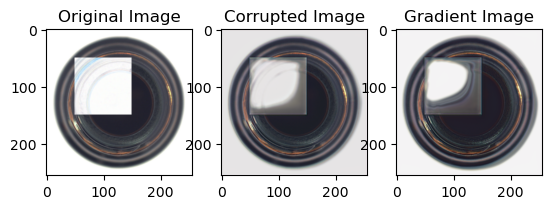

In [15]:
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(corrupted_image_out)
plt.title("Corrupted Image")
plt.subplot(1, 3, 3)
plt.imshow(gradient_image)
plt.title("Gradient Image")

plt.show()

In [19]:
corrupted_image.size()

torch.Size([3, 256, 256])